# FHR signal Processing

## Python Version of 
# `A dataset and a matlab toolbox for`
# `morphological analysis of Fetal Heart Rate signal`
All information at http://ustb.univ-catholille.fr/fhr-review

https://github.com/utsb-fmm/FHR
 
Functionality 
* Matlab function which I decoded in Python, functions names: mat_<matlab name> 
* FHR signal processing functionality, from the git project, function names: fhr_<original function name>

Matlab functionslity is not full with all the options, I just recoded those I needed for the project.
    
I tried to supply matlab test for each function. 

In [13]:
from os.path import dirname, join as pjoin
import scipy.io as sio
import os
import re

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.ndimage import filters
from IPython.display import display, Markdown, Latex
import warnings
import cv2
import os

In [14]:
np.set_printoptions(precision=6)
np.set_printoptions(suppress=True)

In [16]:
np.set_printoptions(edgeitems=9)
np.core.arrayprint._line_width = 180

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.rcParams['figure.figsize'] = [18, 3]
pd.options.display.max_columns = 100

### load preproccessed signal for example

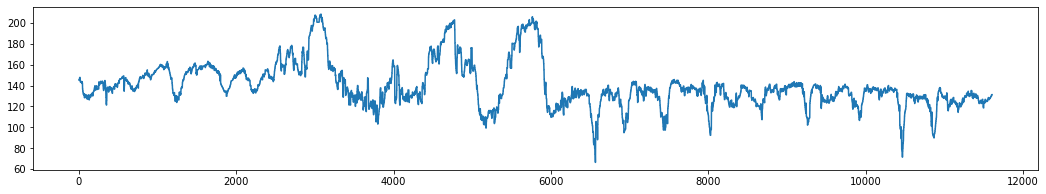

In [17]:
fhr = np.load('fhr_example.npy')
plt.plot(fhr)

# Matlab functions

## Matlab Fir2

In [18]:
import scipy
DEBUG = False

In [19]:
def mat_fix(x):
    if (np.isscalar(x)):
        if (x >= 0):
            return np.floor(x)
        else:
            return (np.rint(x)+1)
  
    return np.where(x>=0, np.floor(x), np.rint(x)+1)
        

In [20]:
def mat_rem(x,y):
    if (y == 0):
        if (type(x)==int):
            return 0
        else: return np.nan
    
    return x % y

In [21]:
#function b = fir2(n, f, m, grid_n, ramp_n, window)
# grid_n and ramp_n must be integers
def mat_fir2(n, f_in, m_in, grid_n = np.nan, ramp_n= np.nan, window = np.nan):

    f = f_in.copy()
    m = m_in.copy()
    
    ## verify frequency and magnitude vectors are reasonable
    t = len(f);
    if (t<2 or f[0]!=0 or f[-1]!=1 or any(np.diff(f)<0)):
        print ("Error fir2: frequency must be nondecreasing starting from 0 and ending at 1");
        return None
    elif t != len(m):
        print ("Error fir2: frequency and magnitude vectors must be the same length");
        return None

    if not np.isnan(grid_n):
        w=grid_n; 
    if not np.isnan(ramp_n):
        w=ramp_n;
    
    if (np.isnan(window)): 
        window = np.hamming(n+1)

    ## Default grid size is 512... unless n+1 >= 1024
    if np.isnan(grid_n):
        if n+1 < 1024:
            grid_n = 512;
        else:
            grid_n = n+1;
    
    ## ML behavior appears to always round the grid size up to a power of 2
    # nextpow2 (MATLAB Functions) p = nextpow2(A) returns the smallest power of two 
    # that is greater than or equal to the absolute value of A.
    # (That is, p that satisfies 2^p >= abs(A) ).
    # This function is useful for optimizing FFT operations, 
    # which are most efficient when sequence length is an exact power of two.
    grid_n =  np.power(2, int(np.ceil(np.log2(abs(grid_n)))))


    ## Error out if the grid size is not big enough for the window
    if (2*grid_n < n+1):
        print ("Error fir2: grid size must be greater than half the filter order");
        return None
  
    
    if np.isnan(ramp_n): ramp_n = mat_fix (grid_n / 25.)
    
    if DEBUG: print('mat_fir2: grid_n', grid_n, 'ramp_n', ramp_n)
    ## Apply ramps to discontinuities
    if (ramp_n > 0):
        ## remember original frequency points prior to applying ramps
        basef = f.copy()
        basem = m.copy()

        ## separate identical frequencies, but keep the midpoint

        idx = np.argwhere(np.diff(f)==0).flatten()
        if DEBUG: print('mat_fir2: idx', idx)
        for i in idx:
            f[i] = f[i] - ramp_n/grid_n/2.;
        if DEBUG: print('mat_fir2: f after idx ', f)
         
        for i in idx:            
            f[i+1] = f[i+1] + ramp_n/grid_n/2.;

        f = np.concatenate([f, [basef[i] for i in idx]])
        ## make sure the grid points stay monotonic in [0,1]
        f[f<0] = 0;
        f[f>1] = 1;
        f = np.unique(np.concatenate([f, [basef[i] for i in idx]]))

        ## preserve window shape even though f may have changed
        m = scipy.interpolate.interp1d(basef, basem)(f)

    
    ## interpolate between grid points
    grid = scipy.interpolate.interp1d(f,m)(np.linspace(0,1,grid_n+1))
    
    ## Transform frequency response into time response and
    ## center the response about n/2, truncating the excess

    if (mat_rem(n,2) == 0):
        x = np.concatenate([grid , grid[grid_n-1:0:-1]])
        b = np.fft.ifft(np.concatenate([grid , grid[grid_n-1:0:-1]]))
        mid = (n+1)/2.;
        b = np.real (np.concatenate([ b[len(b) - int(np.floor(mid)) :] , b[0:int(np.ceil(mid))] ]));
    else:
        ## Add zeros to interpolate by 2, then pick the odd values below.
        b = np.fft.ifft(np.concatenate([grid , np.zeros((grid_n*2)) , grid[grid_n-1:0:-1]]));
        b = 2 * np.real(np.concatenate([ b[len(b)-n::2] , b[1:n+2:2]]));  
    
    ## Multiplication in the time domain is convolution in frequency,
    ## so multiply by our window now to smooth the frequency response.
    ## Also, for matlab compatibility, we return return values in 1 row
    b = np.multiply(b , window)
    return b



### Matlab test
```
f = [0 ,0.6, 0.6 ,1]
m = [1,1, 0, 0]

b17 = fir2(30,f,m,17)
b32 = fir2(30,f,m,32)
assert(b17==b32)
b9  = fir2 (30, f, m, 9)
b16 = fir2 (30, f, m, 16)
assert(b9==b16)
```

In [22]:
scipy.version.version

'1.5.0'

In [24]:
from scipy.interpolate import interp1d

In [25]:
f = [0 ,0.6, 0.6 ,1]
m = [1,1, 0, 0]

b17 = mat_fir2(30,f,m,17)
b17

array([ 0.00064 ,  0.001269, -0.002188, -0.001017,  0.006095, -0.002718,
       -0.011006,  0.014208,  0.010485, -0.034877,  0.007103,  0.060513,
       -0.063157, -0.082137,  0.302197,  0.590625,  0.302197, -0.082137,
       -0.063157,  0.060513,  0.007103, -0.034877,  0.010485,  0.014208,
       -0.011006, -0.002718,  0.006095, -0.001017, -0.002188,  0.001269,
        0.00064 ])

In [26]:

b32 = mat_fir2(30,f,m,32)
b32

array([ 0.00064 ,  0.001269, -0.002188, -0.001017,  0.006095, -0.002718,
       -0.011006,  0.014208,  0.010485, -0.034877,  0.007103,  0.060513,
       -0.063157, -0.082137,  0.302197,  0.590625,  0.302197, -0.082137,
       -0.063157,  0.060513,  0.007103, -0.034877,  0.010485,  0.014208,
       -0.011006, -0.002718,  0.006095, -0.001017, -0.002188,  0.001269,
        0.00064 ])

In [27]:
b17==b32


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [28]:
b9  = mat_fir2 (30, f, m, 9)
b9

array([ 0.000729,  0.002386, -0.003023, -0.002173,  0.008188, -0.002273,
       -0.014185,  0.015372,  0.013656, -0.037633,  0.005003,  0.063962,
       -0.062295, -0.085453,  0.302027,  0.59375 ,  0.302027, -0.085453,
       -0.062295,  0.063962,  0.005003, -0.037633,  0.013656,  0.015372,
       -0.014185, -0.002273,  0.008188, -0.002173, -0.003023,  0.002386,
        0.000729])

In [29]:

b16 = mat_fir2 (30, f, m, 16)
b16

array([ 0.000729,  0.002386, -0.003023, -0.002173,  0.008188, -0.002273,
       -0.014185,  0.015372,  0.013656, -0.037633,  0.005003,  0.063962,
       -0.062295, -0.085453,  0.302027,  0.59375 ,  0.302027, -0.085453,
       -0.062295,  0.063962,  0.005003, -0.037633,  0.013656,  0.015372,
       -0.014185, -0.002273,  0.008188, -0.002173, -0.003023,  0.002386,
        0.000729])

In [30]:
b9==b16

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

## Matlab decimate

In [31]:
def mat_decimate(x, q, n = 0): #function y = decimate(x, q, n, ftype)

    if (n==0):
        n = 8


    [b, a] = signal.cheby1 (n, 0.05, 0.8/q);
    y = signal.filtfilt (b, a, x,  padtype = 'odd', padlen=3*(max(len(b),len(a))-1))

    y = y[0:len(x):q];
    return y


### Matlab test
```
t = linspace(0,2,201)
x=sin(2*pi*t*0.4)
decimate(x,4)
```

> Scipy decimate is close, but not exact

In [34]:
import scipy.signal as signal

In [35]:
t=np.arange(0,2.01,0.01); 
x=np.sin(2*np.pi*t*0.4)
y = signal.decimate(x,4);   # factor of 4 decimation
x.shape, y.shape, y

((201,),
 (51,),
 array([ 0.000366,  0.099003,  0.197906,  0.29377 ,  0.387377,  0.476782,
         0.561265,  0.64046 ,  0.712705,  0.778189,  0.835523,  0.884536,
         0.924654,  0.955298,  0.976471,  0.987623,  0.988912,  0.980168,
         0.961517,  0.933205,  0.895403,  0.848625,  0.793227,  0.729846,
         0.659094,  0.581665,  0.498399,  0.410057,  0.317615,  0.221937,
         0.124025,  0.024881, -0.074562, -0.173182, -0.270132, -0.36429 ,
        -0.454793, -0.540743, -0.62112 , -0.6954  , -0.762455, -0.821987,
        -0.873132, -0.915403, -0.948682, -0.971883, -0.985831, -0.989107,
        -0.982854, -0.966592, -0.940009]))

In [36]:
mat_decimate(x,4)

array([ 0.000025,  0.099471,  0.197418,  0.294219,  0.387051,  0.476934,
        0.561285,  0.64032 ,  0.712898,  0.778008,  0.835651,  0.884478,
        0.924648,  0.955348,  0.976401,  0.987689,  0.988865,  0.98019 ,
        0.961518,  0.933187,  0.895429,  0.848599,  0.793246,  0.729837,
        0.659092,  0.581674,  0.498386,  0.41007 ,  0.317605,  0.22194 ,
        0.12403 ,  0.024869, -0.074545, -0.173199, -0.270121, -0.364291,
       -0.454807, -0.540714, -0.621159, -0.695359, -0.762483, -0.821985,
       -0.873098, -0.915475, -0.94858 , -0.972   , -0.985728, -0.989147,
       -0.982946, -0.966372, -0.94044 ])

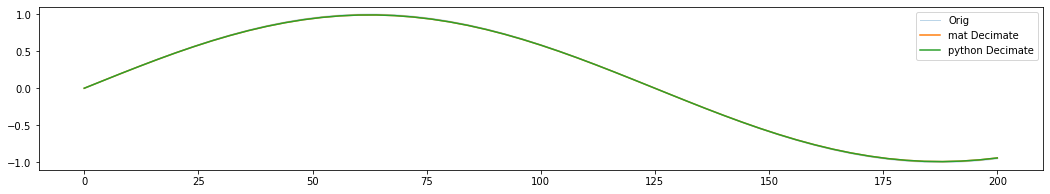

In [37]:
plt.plot(x, label='Orig', lw=1, alpha=0.3)
plt.plot(np.arange(0, 201, 4), mat_decimate(x,4), label = 'mat Decimate')
plt.plot(np.arange(0, 201, 4), signal.decimate(x,4), label = 'python Decimate')
plt.legend()

# mat_interp1
## check vs Octave/Matlab

In [38]:
def mat_interp1(xp,yp,xf):
    lin = scipy.interpolate.interp1d(xp, yp, 'linear')(xf)
    return lin

### Matlab test
```
xf = 0:0.05:10;  
yf = sin (2*pi*xf/5);
xp = 0:10;       
yp = sin (2*pi*xp/5);
lin = interp1 (xp,yp,xf); # , 'linear'); linear is the default
```

In [39]:
xf = np.arange(0, 10.05,0.05)
yf = np.sin (2*np.pi*xf/5);
xp = np.arange(0,11)
yp = np.sin (2*np.pi*xp/5);
lin = scipy.interpolate.interp1d(xp, yp, 'linear')(xf)
lin

array([ 0.      ,  0.047553,  0.095106,  0.142658,  0.190211,  0.237764,
        0.285317,  0.33287 ,  0.380423,  0.427975,  0.475528,  0.523081,
        0.570634,  0.618187,  0.66574 ,  0.713292,  0.760845,  0.808398,
        0.855951,  0.903504,  0.951057,  0.932893,  0.914729,  0.896566,
        0.878402,  0.860239,  0.842075,  0.823912,  0.805748,  0.787584,
        0.769421,  0.751257,  0.733094,  0.71493 ,  0.696767,  0.678603,
        0.66044 ,  0.642276,  0.624112,  0.605949,  0.587785,  0.529007,
        0.470228,  0.41145 ,  0.352671,  0.293893,  0.235114,  0.176336,
        0.117557,  0.058779,  0.      , -0.058779, -0.117557, -0.176336,
       -0.235114, -0.293893, -0.352671, -0.41145 , -0.470228, -0.529007,
       -0.587785, -0.605949, -0.624112, -0.642276, -0.66044 , -0.678603,
       -0.696767, -0.71493 , -0.733094, -0.751257, -0.769421, -0.787584,
       -0.805748, -0.823912, -0.842075, -0.860239, -0.878402, -0.896566,
       -0.914729, -0.932893, -0.951057, -0.903504, 

## Matlab fir1

In [40]:
def mat_fir1(n, w):

    if isinstance(w, (list, tuple, set, np.ndarray)):
        print('mat_fir1: w is an array: ', w)
        return None
    
    ## Assign default window, filter type and scale.
    ## If single band edge, the first band defaults to a pass band to
    ## create a lowpass filter.  If multiple band edges, the first band
    # defaults to a stop band so that the two band case defaults to a
    ## band pass filter.  Ick.
    window  = [];
    scale   = 1;
    ftype   = 1

    ## build response function according to fir2 requirements
    bands = 2
    f = np.zeros((2*bands));
    f[0] = 0; 
    f[-1]=1;
    if DEBUG: print('mat_fir1:  f', f)
    
    f[1:2*bands-1:2] = w #f(2:2:2*bands-1) = w;
    if DEBUG: print('mat_fir1:  f', f)
    f[2:2*bands-1:2] = w #f(3:2:2*bands-1) = w;
    if DEBUG: print('mat_fir1:  f', f)
    
    m = np.zeros((2*bands));
    m[0:2*bands:2] = mat_rem(np.arange(1, bands+1) , 2)   #m(1:2:2*bands) = rem([1:bands]-(1-ftype),2);
    m[1:2*bands:2] = m[0:2*bands:2]   #m(2:2:2*bands) = m(1:2:2*bands);
    if DEBUG: print('mat_fir1:  m', m)
    
    ## Increment the order if the final band is a pass band.  Something
    ## about having a nyquist frequency of zero causing problems.
    if mat_rem(n,2)==1 and m[-1]==1:
        print("mat_fir1: n must be even for highpass and bandstop filters. Incrementing.");
        n = n+1;
        #M = 1
        #window = [window; window];
    if DEBUG: print('mat_fir1:  n', n)
    #print('mat_fir1:  M', M)

    # mat_fir2(n, f_in, m_in, grid_n = np.nan, ramp_n= np.nan, window = np.nan):
    b = mat_fir2(n, f, m, ramp_n = 2)
    if DEBUG: print('mat_fir1:  b', b)
    
      ## normalize filter magnitude
    if scale == 1:
        ## find the middle of the first band edge
        ## find the frequency of the normalizing gain
        if m[0] == 1:
            ## if the first band is a passband, use DC gain
            w_o = 0;
        elif f[3] == 1:
            ## for a highpass filter,
            ## use the gain at half the sample frequency
            w_o = 1;
        else:
            ## otherwise, use the gain at the center
            ## frequency of the first passband
            w_o = f[2] + (f[3]-f[2])/2;
    if DEBUG: print('mat_fir1:  w_o', w_o)

    renorm = 1./np.abs(np.polyval(b, np.exp( complex(0,-1)*np.pi*w_o)));
    if DEBUG: print('mat_fir1:  np.polyval(b, np.exp( complex(0,-1)*np.pi*w_o))', np.polyval(b, np.exp( complex(0,-1)*np.pi*w_o)))
    if DEBUG: print('mat_fir1:  renorm', renorm)
    
    b = renorm*b;
    return b

### Matlab test
```
x = (1:10)
y = sin (2*pi*x/5)
q=2
n = 4
Wc = 0.5
b = fir1(2*q*n+2, Wc/q)
disp(size(b))
disp(b)
```

In [41]:
x = np.linspace(1, 10, num=10, endpoint=True)
y = np.sin (2*np.pi*x/5)
q=2
n = 4
Wc = 0.5
b = mat_fir1(2*q*n+2, Wc/q)
b.shape,b

((19,),
 array([ 0.001935, -0.000105, -0.006131, -0.016364, -0.020294,  0.000602,
         0.058017,  0.141334,  0.217101,  0.247811,  0.217101,  0.141334,
         0.058017,  0.000602, -0.020294, -0.016364, -0.006131, -0.000105,
         0.001935]))

> Scipy firwin is close but not exact

In [42]:
bs = scipy.signal.firwin(2*q*n+2+1, Wc/q, window = "hamming", pass_zero = 'lowpass')
bs.shape, bs

((19,),
 array([ 0.001991, -0.      , -0.006003, -0.016366, -0.020612,  0.      ,
         0.05749 ,  0.141337,  0.217772,  0.248785,  0.217772,  0.141337,
         0.05749 ,  0.      , -0.020612, -0.016366, -0.006003, -0.      ,
         0.001991]))

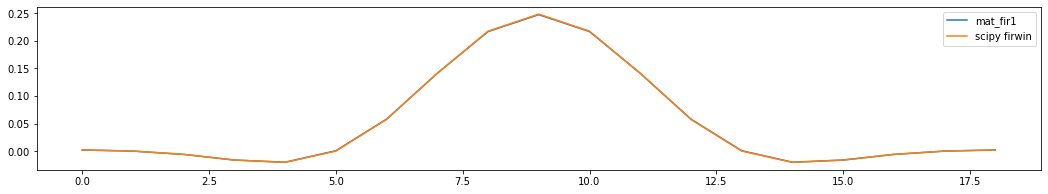

In [43]:
plt.plot(b, label='mat_fir1')
plt.plot(bs, label='scipy firwin')
plt.legend()

## Matlab fftfilt

In [46]:
def mat_fftfilt (b, x, n = np.nan):

    ## If N is not specified explicitly, we do not use the overlap-add
    ## method at all because loops are really slow.  Otherwise, we only
    ## ensure that the number of points in the FFT is the smallest power
    ## of two larger than N and length(b).  This could result in length
    ## one blocks, but if the user knows better ...

    # make sure shape is (len,1)
    #x = x.reshape((len(x),1))
    #b = b.reshape((len(b),1))
    r_x = len(x)
    c_x = 1
    r_b = 1
    c_b = len(b)

    l_b = r_b * c_b;
    print('b', b.shape,b)
    #b = b.reshape ((b, l_b, 1));

    if (np.isnan(n)):
        ## Use FFT with the smallest power of 2 which is >= length (x) +
        ## length (b) - 1 as number of points ...
        n = int(2 ** np.ceil(np.log2(abs(r_x + l_b - 1))))
        print('n', n)
        print('b', b)
        B = np.fft.fft (b, n)
        #B = B.reshape((len(B), 1))
        #B = np.repeat(B, c_x, axis=1)
        print('B', B.shape, B)
        print('np.fft.fft (x, n)', np.fft.fft (x, n), np.fft.fft (x, n).shape)
        y = np.fft.ifft (np.multiply(np.fft.fft (x, n) ,B))#B(:, ones (1, c_x)));
        print('y', y.shape, y)
  
    else:
        #n = 2 ^ nextpow2 (max ([n, l_b]));
        n = int(2 ** np.ceil(np.log2(abs(max ([n, l_b])))))
        L = n - l_b + 1;
        B = np.fft.fft (b, n)#.reshape((len(B), 1))
        #B = np.repeat(B, c_x, axis=1)

        #B = B(:, ones (c_x,1));

        R = int(np.ceil (r_x / L))
        y = np.zeros ((r_x, c_x));
        print('R', R)
        for r in range(R): #r = 1:R
            lo = (r - 1) * L + 1;
            hi = min (r * L, r_x);
            tmp = np.zeros ((n, c_x));
            print('tmp', tmp.shape)
            print('x[lo:hi+1,:]', x[lo:hi+1,:], x[lo:hi+1,:].shape)
            tmp[0:(hi-lo+1+1),:] = x[lo:hi+1,:];
            tmp = np.fft.ifft (np.multiply(np.fft.fft (tmp) , B));
            hi  = min (lo+n-1, r_x);
            y[lo:hi+1,:] = y[lo:hi+1,:] + tmp[0:(hi-lo+1+1),:];

    print('**y', y.shape,y)
    y = y[0:r_x]
    print('y', y.shape,y)

    ## Final cleanups:

    ## - If both b and x are real, y should be real.
    ## - If b is real and x is imaginary, y should be imaginary.
    ## - If b is imaginary and x is real, y should be imaginary.
    ## - If both b and x are imaginary, y should be real.
    xisreal = np.all ( np.isreal(x) == 1)
    xisimag = np.all ( np.isreal(x) == 0)
    print('xisreal', xisreal)
    print('xisimag', xisimag)

    if (np.all ( np.isreal(b) == 1)):
        if (xisreal):
            #xisreal = 1 xisimag = 0
            y = np.real (y );
        else:

            #xisreal = 0 xisimag = 1
            y = np.complex (np.real (y ) * 0, np.image (y ));

    elif (np.all ( np.isreal(x) == 0)):
        if (xisimag):
            #xisreal = 0 xisimag = 1
            y  = np.real (y);
        else:
            #xisreal = 1 xisimag = 0
            y  = np.complex (np.real (y ) * 0, np.image (y ));
            

    ## - If both x and b are integer in both real and imaginary
    ##   components, y should be integer.
    if (not np.any (b - mat_fix (b))):
        idx = np.argwhere(not np.any (x - mat_fix (x))).flatten()
        
        y [idx] = np.round (y [idx]);
        
    return y



In [47]:
def mat_fftfilt (b, x, n = np.nan):

    ## If N is not specified explicitly, we do not use the overlap-add
    ## method at all because loops are really slow.  Otherwise, we only
    ## ensure that the number of points in the FFT is the smallest power
    ## of two larger than N and length(b).  This could result in length
    ## one blocks, but if the user knows better ...

    # make sure shape is (len,1)
    #x = x.reshape((len(x),1))
    #b = b.reshape((len(b),1))
    r_x = len(x)
    c_x = 1
    r_b = 1
    c_b = len(b)

    l_b = r_b * c_b;
    if DEBUG: print('mat_fftfilt: b', b.shape,b)
    #b = b.reshape ((b, l_b, 1));

    if (np.isnan(n)):
        ## Use FFT with the smallest power of 2 which is >= length (x) +
        ## length (b) - 1 as number of points ...
        n = int(2 ** np.ceil(np.log2(abs(r_x + l_b - 1))))
        B = np.fft.fft (b, n)
        y = np.fft.ifft (np.multiply(np.fft.fft (x, n) ,B))#B(:, ones (1, c_x)));
  
    else:
        #n = 2 ^ nextpow2 (max ([n, l_b]));
        n = int(2 ** np.ceil(np.log2(abs(max ([n, l_b])))))
        L = n - l_b + 1;
        B = np.fft.fft (b, n)#.reshape((len(B), 1))
        R = int(np.ceil (r_x / L))
        y = np.zeros ((r_x, c_x));
        for r in range(R): #r = 1:R
            lo = (r - 1) * L + 1;
            hi = min (r * L, r_x);
            tmp = np.zeros ((n, c_x));
            tmp[0:(hi-lo+1+1),:] = x[lo:hi+1,:];
            tmp = np.fft.ifft (np.multiply(np.fft.fft (tmp) , B));
            hi  = min (lo+n-1, r_x);
            y[lo:hi+1,:] = y[lo:hi+1,:] + tmp[0:(hi-lo+1+1),:];

    y = y[0:r_x]

    ## Final cleanups:

    ## - If both b and x are real, y should be real.
    ## - If b is real and x is imaginary, y should be imaginary.
    ## - If b is imaginary and x is real, y should be imaginary.
    ## - If both b and x are imaginary, y should be real.
    xisreal = np.all ( np.isreal(x) == 1)
    xisimag = np.all ( np.isreal(x) == 0)


    if (np.all ( np.isreal(b) == 1)):
        if (xisreal):
            #xisreal = 1 xisimag = 0
            y = np.real (y );
        else:

            #xisreal = 0 xisimag = 1
            y = np.complex (np.real (y ) * 0, np.image (y ));

    elif (np.all ( np.isreal(x) == 0)):
        if (xisimag):
            #xisreal = 0 xisimag = 1
            y  = np.real (y);
        else:
            #xisreal = 1 xisimag = 0
            y  = np.complex (np.real (y ) * 0, np.image (y ));
            

    ## - If both x and b are integer in both real and imaginary
    ##   components, y should be integer.
    if (not np.any (b - mat_fix (b))):
        idx = np.argwhere(not np.any (x - mat_fix (x))).flatten()
        
        y [idx] = np.round (y [idx]);
        
    return y



#### Matlab test
```
b = [1 ,1]
x = zeros(1, 9)
x(1) = 1
fftfilt (b,  x  )
```

In [48]:
b = np.array([1 ,1]);
x = np.zeros(9)
x[0] = 1
mat_fftfilt (b,  x  )

array([ 1.,  1.,  0.,  0.,  0.,  0.,  0., -0.,  0.])

#### Matlab test
```
g1 = [0.0010688,  -0.0018944,  -0.0090799,  -0.0176958,  -0.0129548]
q1 = [0.95106 ,  0.00000 ,  0.58779 ,  0.00000 , -0.58779]
fftfilt(g1,q1)
```

In [49]:
g1 = np.array([0.0010688,  -0.0018944,  -0.0090799,  -0.0176958,  -0.0129548])
q1 = np.array([0.95106 ,  0.00000 ,  0.58779 ,  0.00000 , -0.58779])
mat_fftfilt(g1,q1)

array([ 0.001016, -0.001802, -0.008007, -0.017943, -0.018286])

## Matlab interp1

#### Matlab
##### interp1 - 1-D data interpolation 
**vq = interp1(x,v,xq)** returns interpolated values of a 1-D function at specific query points using linear interpolation. Vector x contains the sample points, and v contains the corresponding values, v(x). Vector xq contains the coordinates of the query points.

If you have multiple sets of data that are sampled at the same point coordinates, then you can pass v as an array. Each column of array v contains a different set of 1-D sample values.


**vq = interp1(x,v,xq,method)** specifies an alternative interpolation method: 'linear', 'nearest', 'next', 'previous', 'pchip', 'cubic', 'v5cubic', 'makima', or 'spline'. The default method is 'linear'.

Matlab Test
```
xf = [0:0.05:10];
yf = sin (2*pi*xf/5);
xp = [0:10];
yp = sin (2*pi*xp/5);
lin = interp1 (xp, yp, xf);
near = interp1 (xp, yp, xf, "nearest");
pch = interp1 (xp, yp, xf, "pchip");
spl = interp1 (xp, yp, xf, "spline");
plot (xf,yf,"r", xf,near,"g", xf,lin,"b", xf,pch,"c", xf,spl,"m",
    xp,yp,"r*");
legend ("original", "nearest", "linear", "pchip", "spline");
```

#### Python Scipy
**scipy.interpolate.interp1d(x, y, kind='linear', axis=-1, copy=True, bounds_error=None, fill_value=nan, assume_sorted=False)**

Interpolate a 1-D function.

x and y are arrays of values used to approximate some function f: y = f(x). This class returns a function whose call method uses interpolation to find the value of new points.
http://wwwens.aero.jussieu.fr/lefrere/master/SPE/docs-python/scipy-doc/generated/scipy.interpolate.interp1d.html

> **kind : str or int, optional**
> Specifies the kind of interpolation as a string (‘linear’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic, ‘cubic’ where ‘slinear’, ‘quadratic’ and ‘cubic’ refer to a spline interpolation of first, second or third order) or as an integer specifying the order of the spline interpolator to use. Default is ‘linear’.

In [50]:
def mat_interp1(x, y, xnew, kind='linear'):
    
    if kind == 'spline':
        kind='cubic'
    if not kind in ['linear', 'cubic']:
        print('mat_interp1: ', kind, ' Not supported')
        return None
    f = scipy.interpolate.interp1d(x, y, kind)
    return f(xnew)

#### Matlab test
```
x = linspace(0, 10, 11)
y = cos(-x.^2/9.0)
xnew = linspace(0, 10, 41)
f = interp1(x, y, xnew)
fs = interp1(x, y, xnew,'spline')
```

In [51]:
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
xnew = np.linspace(0, 10, num=41, endpoint=True)
mat_interp1(x, y, xnew)

array([ 1.      ,  0.998458,  0.996917,  0.995375,  0.993834,  0.971088,
        0.948342,  0.925596,  0.90285 ,  0.812213,  0.721576,  0.630939,
        0.540302,  0.35385 ,  0.167398, -0.019054, -0.205507, -0.387767,
       -0.570026, -0.752286, -0.934546, -0.864321, -0.794095, -0.723869,
       -0.653644, -0.323133,  0.007378,  0.337889,  0.6684  ,  0.670401,
        0.672402,  0.674404,  0.676405,  0.279521, -0.117363, -0.514246,
       -0.91113 , -0.654528, -0.397925, -0.141323,  0.11528 ])

In [52]:
mat_interp1(x, y, xnew, 'spline')

array([ 1.      ,  0.996411,  0.996091,  0.996185,  0.993834,  0.986181,
        0.970371,  0.943546,  0.90285 ,  0.845363,  0.767926,  0.667313,
        0.540302,  0.385087,  0.205529,  0.006905, -0.205507, -0.424039,
       -0.631466, -0.808174, -0.934546, -0.992676, -0.971483, -0.861596,
       -0.653644, -0.348845,  0.009214,  0.366355,  0.6684  ,  0.867957,
        0.944783,  0.885418,  0.676405,  0.320132, -0.117628, -0.555255,
       -0.91113 , -1.103634, -1.051146, -0.672048,  0.11528 ])

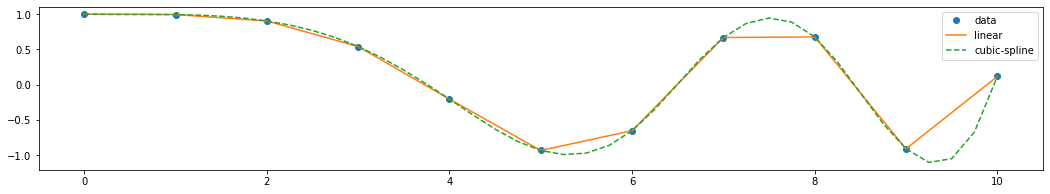

In [53]:
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)


xnew = np.linspace(0, 10, num=41, endpoint=True)
f = mat_interp1(x, y, xnew)
f2 = mat_interp1(x, y, xnew, kind='spline')

plt.plot(x, y, 'o', xnew, f, '-', xnew, f2, '--')
plt.legend(['data', 'linear', 'cubic-spline'], loc='best')
plt.show()

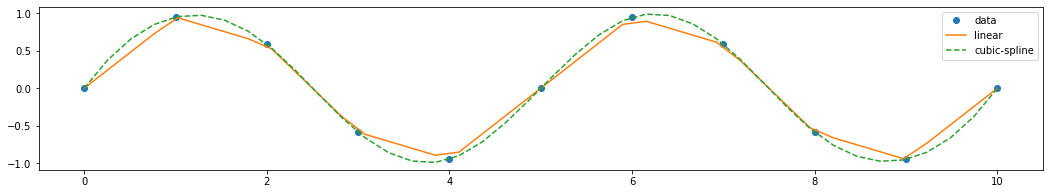

In [54]:
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.sin (2*np.pi*x/5)


xnew = np.linspace(0, 10, num=40, endpoint=True)
f = mat_interp1(x, y, xnew)
f2 = mat_interp1(x, y, xnew, kind='spline')

plt.plot(x, y, 'o', xnew, f, '-', xnew, f2, '--')
plt.legend(['data', 'linear', 'cubic-spline'], loc='best')
plt.show()

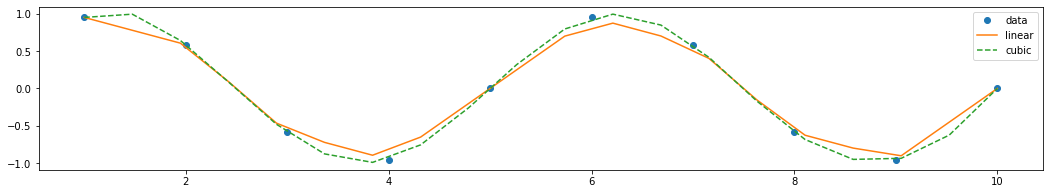

In [55]:
t = np.linspace(1, 10, num=10, endpoint=True)
x = np.sin (2*np.pi*t/5)
f = scipy.interpolate.interp1d(t, x)
f2 = scipy.interpolate.interp1d(t, x, kind='cubic')

tnew = np.linspace(1, 10, num=20, endpoint=True)
y = f2(tnew)
import matplotlib.pyplot as plt
plt.plot(t, x, 'o', tnew, f(tnew), '-', tnew, f2(tnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

## Matlab interp

In [56]:
def  mat_interp(x, q, n = 4, Wc = 0.5):

    if DEBUG: print('mat_interp:\n', '** mat_interp **')
    if q != mat_fix(q):
        print("decimate only works with integer q.")
        return np.nan

    y = np.zeros(len(x)*q+q*n+1)
    if DEBUG: print('mat_interp:len(x)*q+q*n+1', len(x)*q+q*n+1)

    y[0:len(x)*q:q] = x;
    if DEBUG: print('mat_interp:------------xxxxxxxxxxxxxxxxxxx------  y', y)

    b = mat_fir1(2*q*n+1, Wc/q);
    y=q*mat_fftfilt(b, y);
  
    # ? y(1:q*n+1) = [];  # adjust for zero filter delay

    return y[q*n+1:]

#### Matlab test
```
x = (1:10)
y = sin (2*pi*x/5)
interp(y, 2)
```

In [57]:
x = np.linspace(1, 10, num=10, endpoint=True)
y = np.sin (2*np.pi*x/5)

In [58]:
m = mat_interp(y, 2)
m.shape, m

((20,),
 array([ 0.674796,  0.540432,  0.202501, -0.222119, -0.574285, -0.711368,
        -0.5747  , -0.221134,  0.221134,  0.5747  ,  0.711368,  0.574285,
         0.222119, -0.202501, -0.540432, -0.674796, -0.601125, -0.397072,
        -0.175939, -0.026425]))

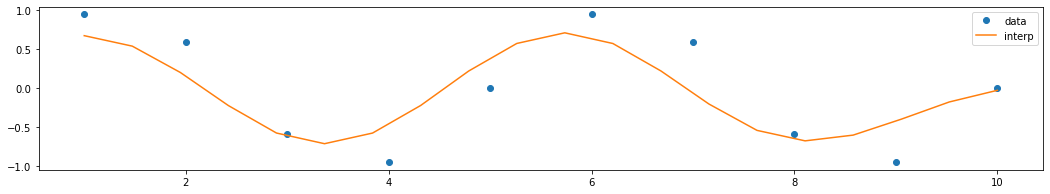

In [59]:

plt.plot(x, y, 'o')
plt.plot( np.linspace(1, 10, len(m)),m, '-')
plt.legend(['data', 'interp'], loc='best')
plt.show()

# Fhr functionality for FHR baseline calculation

In [60]:
def fhr_avgsubsamp(x,factor):
    
    y=np.zeros((int(np.floor(len(x)/factor))));
    for i in range(len(y)):
        y[i]=np.mean(x[i*factor+1:(i+1)*factor]);
    return y

## BUTTERFILT Complete butterworth filter process 

In [61]:
from scipy import signal

In [62]:

def fhr_butterfilt(data, srate, f1, f2, order = 6, zeroPhase = 1):
    
    if DEBUG: print('fhr_butterfilt: order', order)
    assert(zeroPhase==1)
    if ((f1>0) and (f2==0)):
        b1,a1 = signal.butter(order, 2*f1/srate,'highpass', output='ba')

    elif (f1==0 and f2>0):
        b1,a1 = signal.butter(order, 2*f2/srate,'lowpass', output='ba')
        
    elif (f1>0 and f2>0 and f2<f1):
        b1,a1 = signal.butter(order, [2.*f2/srate ,2.*f1/srate],btype='band', output='ba')
            
    elif (f1>0 and f2>0 and f2>f1):
                
        z, p, k = signal.butter(1, [2.*f1/srate, 2.*f2/srate], btype='bandpass', output='zpk')
        b1, a1 = signal.zpk2tf(z, p, k)

    if DEBUG: print('fhr_butterfilt:a1', a1)
    if DEBUG: print('fhr_butterfilt:b1', b1)

    if zeroPhase:
        
        nfilt = max(len(b1),len(a1))

        a1 = np.pad(a1, (0,nfilt-len(a1)), mode='constant',)
        b1 = np.pad(b1, (0,nfilt-len(b1)), mode='constant',)
        data=signal.filtfilt(b1,a1,data, padtype = 'odd', padlen=3*(max(len(b1),len(a1))-1))
        
    #else:
    #    
    #    data=signal.filter(b1,a1,data)
    #    print('data',data)
        
    return data

In [63]:
d = np.arange(1,26)
fhr_butterfilt(d,240, 0 , 1 , 1 )

array([4.112521, 4.270477, 4.42999 , 4.590482, 4.75138 , 4.912107,
       5.072088, 5.230748, 5.387509, 5.541793, 5.693021, 5.840611,
       5.983977, 6.122534, 6.25569 , 6.382851, 6.503418, 6.61679 ,
       6.722357, 6.819506, 6.90762 , 6.986072, 7.05423 , 7.111457,
       7.157105])

In [64]:
FHRi = [100, 102, 103, 104, 105, 102, 100]
fhr_butterfilt(FHRi, 3, 0, 1,1)

array([ 99.994081, 101.878498, 102.991928, 104.153789, 104.392915,
       102.27455 , 100.008883])

In [65]:
fhr_butterfilt(FHRi,240,4,0,1)

array([2.662595, 4.591988, 5.569214, 6.607795, 7.71917 , 4.904568,
       3.146751])

## Method Weigthed Median Filter Baseline (WMFB)

In [66]:
def fhr_enveloppe(x,srate,f0,f1, deb = False): #function [y,x]=

    fftx=np.fft.fft(x);
    if (deb):
        print('fhr_enveloppe: fftx', fftx.shape, fftx)#[:10])
        
    siglen=len(x)/srate;
    if (deb):
        print('*********** np.round(f0*siglen+1)', np.round(f0*siglen+1))
        print('*********** (f0*siglen+1)', (f0*siglen+1))
    firstsamp=int(np.round(f0*siglen+1))
    lastsamp=int(np.round(f1*siglen+1))
    if (deb):
        print('fhr_enveloppe: firstsamp, lastsamp', firstsamp, lastsamp)
        print('(lastsamp-firstsamp) %2', (lastsamp-firstsamp) %2)
    ffty=np.zeros(x.shape,dtype=complex);

    iend = int((lastsamp-firstsamp-1)/2)
    if ((lastsamp-firstsamp) % 2 ==0): iend += 1
    if (deb):
        print('fhr_enveloppe: iend, from', iend, fftx[firstsamp-1:firstsamp-1+iend])
        print('fhr_enveloppe: iend, to', ffty[-iend:])
        print('fhr_enveloppe: iend', iend)
    
    #if(mod(lastsamp-firstsamp,2)==1) 
    #    ffty([end-(lastsamp-firstsamp-3)/2:end 1:(3+lastsamp-firstsamp)/2])=fftx(firstsamp:lastsamp);
    # else
    #   ffty([end-(lastsamp-firstsamp-2)/2:end 1:(2+lastsamp-firstsamp)/2])=fftx(firstsamp:lastsamp);
    if (lastsamp-firstsamp) %2 ==1:

        if (firstsamp-1+int((lastsamp-firstsamp-1)/2) >= firstsamp-1):

            ffty[len(ffty) - 1 - int((lastsamp-firstsamp-3)/2):] = fftx[firstsamp-1:iend]

        if (lastsamp > firstsamp-1+int((lastsamp-firstsamp-1)/2)):
            #ffty[:int((3+lastsamp-firstsamp)/2)] = fftx[firstsamp-1+len(ffty) - int((lastsamp-firstsamp-3)/2):lastsamp]
            ffty[:int((3+lastsamp-firstsamp)/2)] = fftx[firstsamp-1+iend:lastsamp]

        
    else:
        
        ffty[len(ffty)-1 - int((lastsamp-firstsamp-2)/2):] = fftx[firstsamp-1:firstsamp-1+len(ffty[len(ffty)-1 - int((lastsamp-firstsamp-2)/2):])]
        ffty[:int((2+lastsamp-firstsamp)/2)] = fftx[lastsamp-int((2+lastsamp-firstsamp)/2):lastsamp]


        

    fftx[:(firstsamp-1)] = 0.     #fftx[:(firstsamp-1)] = 0.

    fftx[lastsamp:len(fftx)-lastsamp+1] = 0

    fftx[len(fftx)-firstsamp+1:] = 0

    
    if (deb):
        print('fhr_enveloppe: before ifft fftx[0:10]', fftx.size, fftx)#[:10])
    x=np.fft.ifft(fftx);
    y=2*abs(np.fft.ifft(ffty));
    
    return y, x


In [67]:
x = np.array([ 0.00000 , -2.94432 , -3.25624 , -3.58069 , -3.80474 , -4.00056 , -4.24025 , -4.46229 , -4.60511 , -4.78194])
y, x = fhr_enveloppe(x,240,0,2)
x,y

(array([-3.567614+0.j, -3.567614+0.j, -3.567614+0.j, -3.567614+0.j,
        -3.567614+0.j, -3.567614+0.j, -3.567614+0.j, -3.567614+0.j,
        -3.567614+0.j, -3.567614+0.j]),
 array([7.135228, 7.135228, 7.135228, 7.135228, 7.135228, 7.135228,
        7.135228, 7.135228, 7.135228, 7.135228]))

In [68]:

d = np.array([100, 101, 102, 103, 150, 150, 104, 105, 60, 30, 1, 8 , 9])
srate = 24
f0 = 0
f1 = 3
y, x = fhr_enveloppe(d,srate,f0,f1)
y, x

(array([162.115492, 183.898243, 195.167483, 202.075314, 209.045438,
        214.24796 , 210.980688, 192.937928, 158.585609, 114.203766,
         80.609933,  90.712706, 128.052323]),
 array([ 70.48059 +0.j,  97.2047  +0.j, 112.670902+0.j, 121.965467+0.j,
        130.195564+0.j, 135.067924+0.j, 127.766531+0.j, 101.623908+0.j,
         60.85336 +0.j,  21.117687+0.j,   0.478983+0.j,   7.521301+0.j,
         36.053084+0.j]))

In [69]:

d = np.array([100, 101, 102, 103, 150, 150, 104, 105, 60, 30, 1, 8 , 9])
srate = 24
f0 = 3
f1 = 4
y, x = fhr_enveloppe(d,srate,f0,f1)
y, x

(array([15.396056, 15.396056, 15.396056, 15.396056, 15.396056, 15.396056,
        15.396056, 15.396056, 15.396056, 15.396056, 15.396056, 15.396056,
        15.396056]),
 array([ 7.549516-1.504804j,  5.527043+5.358304j, -1.27008 +7.592531j,
        -6.970018+3.267794j, -6.648763-3.879894j, -0.583838-7.675856j,
         5.985448-4.840873j,  7.384082+2.175998j,  2.403825+7.313088j,
        -4.653025+6.132617j, -7.690264-0.345641j, -4.084111-6.52531j ,
         3.050185-7.067956j]))

In [70]:

d = np.array([100, 101, 102, 103, 150, 150, 104,105, 60, 30, 1, 8 , 9])
srate = 24
f0 = 3
f1 = 4
y, x = fhr_enveloppe(d,srate,f0,f1)
y, x

(array([15.396056, 15.396056, 15.396056, 15.396056, 15.396056, 15.396056,
        15.396056, 15.396056, 15.396056, 15.396056, 15.396056, 15.396056,
        15.396056]),
 array([ 7.549516-1.504804j,  5.527043+5.358304j, -1.27008 +7.592531j,
        -6.970018+3.267794j, -6.648763-3.879894j, -0.583838-7.675856j,
         5.985448-4.840873j,  7.384082+2.175998j,  2.403825+7.313088j,
        -4.653025+6.132617j, -7.690264-0.345641j, -4.084111-6.52531j ,
         3.050185-7.067956j]))

## FHR medgliss

In [74]:
#*************************************************************************
def fhr_medgliss(X,win,coef,decim,X2 = np.nan,p2 = np.nan,c = np.nan, nargs=4): # [Y,mp]=medgliss(X,win,coef,decim,X2,p2,c)

    if DEBUG: print('+++medgliss',X,win,coef,decim,X2,p2,c )
    
    Xd=fhr_butterfilt(X,240,0,240/2.2/decim,8,1);
    
    Xd=Xd[0::decim]
    if (nargs>4):
        X2=X2[0::decim]

    coefd= mat_decimate(coef,decim);
    coefd=np.where(coefd > 0, coefd, 0)#coefd.*(coefd>0);
    midwin=(len(win)-1)/2;
    Yd=np.zeros((Xd.shape));

    mintolerated=np.zeros(len(Xd));
    maxtolerated=255*np.ones((len(Xd)));
    
    if DEBUG: print('fhr_medgliss: 10*240/decim', 10*240/decim, '240/2/decim', 240/2/decim, 'len(Xd)-10*240/decim', len(Xd)-10*240/decim)
    if DEBUG: print('fhr_medgliss: len(Xd)', len(Xd), '-10*240/decim', -10*240/decim)
    for i in range(0,int(240/2/decim), len(Xd)-int(10*240/decim)):
        twin= np.arange(i,i+10*240./decim).astype(int)
        
        mi=min(Xd[twin.astype(int)]);
        ma=max(Xd[twin.astype(int)]);

        mintolerated[twin[mintolerated[twin]<=mi]]=mi;
        maxtolerated[twin[maxtolerated[twin]<=ma]]=ma;
    
    mp = np.zeros((len(Xd)))
    
    for i in range(len(Xd)):
        if(i<midwin):
            mwm=i;
            if DEBUG: 
                print('fhr_medgliss: np.floor((midwin-mwm)/2)', np.floor((midwin-mwm)/2),'len(Xd)-(i+1)',len(Xd)-(i+1) )
                print('fhr_medgliss: max of', mwm, np.floor((midwin-mwm)/2))
                print('fhr_medgliss: np.max(mwm, np.floor((midwin-mwm)/2))',max(mwm, np.floor((midwin-mwm)/2)))
            mwp=min(max(mwm, np.floor((midwin-mwm)/2)), len(Xd)-(i+1));
        elif(len(Xd)-(i+1)<midwin):#??? -i + 1
            mwp=len(Xd)-(i+1);
            mwm=min(max(mwp, np.floor((midwin-mwp)/2)), i);
        else:
            mwm=midwin;
            mwp=midwin;
        
        if DEBUG: print('fhr_medgliss:i', i, 'mwm', mwm, 'mwp', mwp)
        points=np.arange(i-mwm,i+mwp+1).astype(int)
        if DEBUG: print('fhr_medgliss: ----------------8888888888888---------------points\n',points)
        if DEBUG: print('fhr_medgliss: ----------------8888888888888---------------Xd\n',Xd)
        Xpoints=Xd[points];
        if DEBUG: print('fhr_medgliss: ----------------8888888888888---------------Xpoints\n',Xpoints)
        if DEBUG: 
            print('fhr_medgliss: win[209:210]',win.shape, win[209:210])
            print('fhr_medgliss: coefd[points]', coefd[points])
            print('fhr_medgliss: midwin-mwm+1:midwin+mwp+1', midwin-mwm+1,midwin+mwp+1)
            print('fhr_medgliss: win[midwin-mwm+1:midwin+mwp+1]',win[int(midwin-mwm+1):int(midwin+mwp+1+1)])

        tmp = np.where((Xpoints>=mintolerated[i]) & (Xpoints<=maxtolerated[i]), 1, 0)
        if DEBUG: print('fhr_medgliss: coefd[points].shape', coefd[points].shape, 'win[int(midwin-mwm+1):int(midwin+mwp+1+1)].shape', 
              win[int(midwin-mwm):int(midwin+mwp+1)].shape)
        coefwin=np.multiply(coefd[points],win[int(midwin-mwm):int(midwin+mwp+1)])
        if DEBUG: print('fhr_medgliss: coefwin', coefwin)
        coefwin=np.multiply(tmp,coefwin)
        if DEBUG: print('fhr_medgliss: coefwin', coefwin)
                             
        s=coefwin.sum()
        if DEBUG: print('fhr_medgliss: ---------------------s', s)
        scoef=win[int(midwin-mwm):int(midwin+mwp+1)].sum()
        if DEBUG: print( 'fhr_medgliss: scoef', scoef)

        if nargs>4:
            if DEBUG: print('fhr_medgliss: i, Xpoints, X2[i]',i, Xpoints, X2[i])
            Xpoints= np.concatenate([Xpoints , np.array([X2[i]])])
            if DEBUG: print('fhr_medgliss: coefwin, np.array([np.max(0,c*p2[i]*scoef-s)])',coefwin,c*p2[i]*scoef-s)
            if DEBUG: print('fhr_medgliss:', max(0,c*p2[i]*scoef-s) )
            coefwin= np.concatenate([coefwin, np.array([max(0,c*p2[i]*scoef-s)])]);
            s=coefwin.sum();
        
        #[p,order]=sort(Xpoints);
        
        order = np.argsort(Xpoints)
        if DEBUG: print('fhr_medgliss:order', order)
        p = np.sort(Xpoints)
        if DEBUG: print('fhr_medgliss: p', p)
        if DEBUG: print('fhr_medgliss: coefwin[order]', coefwin[order])
        if DEBUG: print('fhr_medgliss: coefwin', coefwin)
        # find(X,1,'first') finds the first  index corresponding to nonzero elements.
        #Yd[i]=p(find(cumsum(coefwin(order))>=s/2,1,'first'));
        #t = array([1, 1, 1, 2, 2, 3, 8, 3, 8, 8])
        #nonzero(t == 8)[0][0]
        if DEBUG: print('fhr_medgliss: np.nonzero(np.cumsum(coefwin[order])>=s/2)', np.nonzero(np.cumsum(coefwin[order])>=s/2))
        Yd[i]  = p[np.nonzero(np.cumsum(coefwin[order])>=s/2)[0][0]]
        if DEBUG: print('===============i', i,'Yd', Yd)
        if DEBUG: print('fhr_medgliss: i', i, 'Yd[i]',Yd[i])
        if DEBUG: print('fhr_medgliss: ************** s/scoef', s/scoef)
        mp[i]=s/scoef;

    if DEBUG: 
        print('fhr_medgliss: mp', mp)
        print('fhr_medgliss: Yd', Yd)
        print('fhr_medgliss: decim', decim)
    Y=mat_interp(Yd,decim);
    Y=Y[:len(X)];

    mp=mat_interp(mp,decim);
    mp=mp[:len(X)];

    return Y, mp

# Matlab test
```
d = (1:25)
FHR2 = butterfilt(d,50,0,2,1)
distancecoef=[linspace(0,1, num=20) 1 linspace(1,0, num=20)]
t = ones(25,4)
Q=[-2.4744    0.0266    0.0413    0.0105    0.0036]';
P=1-exp(Q(1)+t*Q(2:end))./(1+exp(Q(1)+t*Q(2:end)));
medgliss(FHR2,distancecoef,P,24)
```

In [79]:
d = np.arange(1,26)
FHR2=fhr_butterfilt(d,50,0,2,1);
Q=[-2.4744  ,  0.0266  ,  0.0413  ,  0.0105 ,   0.0036]
distancecoef=np.concatenate([np.linspace(0,1, num=200), np.ones((1)), np.linspace(1,0, num=200)])
t = np.ones((25,4))
P = 1-np.divide(np.exp(Q[0]+t.dot(Q[1:])),(1+np.exp(Q[0]+t.dot(Q[1:]))))

In [80]:

fhr_medgliss(FHR2,distancecoef,P,24)

(array([0.451132, 0.458633, 0.465538, 0.471824, 0.477469, 0.482453,
        0.486758, 0.490369, 0.493274, 0.495462, 0.496924, 0.497657,
        0.497657, 0.496924, 0.495462, 0.493274, 0.490369, 0.486758,
        0.482453, 0.477469, 0.471824, 0.465538, 0.458633, 0.451132,
        0.443062]),
 array([0.684289, 0.695666, 0.70614 , 0.715675, 0.724237, 0.731797,
        0.738327, 0.743805, 0.748211, 0.751529, 0.753748, 0.754859,
        0.754859, 0.753748, 0.751529, 0.748211, 0.743805, 0.738327,
        0.731797, 0.724237, 0.715675, 0.70614 , 0.695666, 0.684289,
        0.672048]))

## FHR aamwmfb

In [81]:
# strate = 240

def fhr_aamwmfb(FHRi, deb = DEBUG): #function [baseline,accelerations,decelerations,falseAcc,falseDec]=aamwmfb(FHRi)

    st = 240
    
    FHR1=fhr_butterfilt(FHRi,240,0,1,1);
    
    FHR2=fhr_butterfilt(FHRi,240,0,2,1);
    
    FHR4=fhr_butterfilt(FHRi,240,0,4,1);
    
    FHR8=fhr_butterfilt(FHRi,240,0,8,1);
    
    FHR16=fhr_butterfilt(FHRi,240,0,16,1);
    

    fcut=[0 ,1 ,3 ,7]
    fdat=np.zeros((3,2, len(FHRi)), dtype=np.float64)

    for j in range(3):#j=1:3
        if DEBUG: print('aamwmfb: ',fcut[j],fcut[j+1])
        fdat[j,0]=fhr_butterfilt(FHRi,240,fcut[j],fcut[j+1],1);
        if DEBUG: print('aamwmfb: --- j',j)
        if DEBUG: print('aamwmfb: fdat[j,0]=fhr_butterfilt(FHRi,240,',fcut[j],',',fcut[j+1],',',1,')')
        if DEBUG: print('aamwmfb: ',fdat[j,0])
        
        if DEBUG: print('aamwmfb: ',fdat[j,1][1:].shape)
        fdat[j,1]=np.concatenate([np.zeros((1)), fdat[j,0][1:]-fdat[j,0][:-1]])*240.;

    
    t = np.zeros((len(FHRi), 4), dtype=np.float64)
    if DEBUG: print('aamwmfb: ',fdat[0,1].size)
    t[:,0] = np.abs(fdat[0,1])
    if DEBUG: print('aamwmfb: t[:,0]', t[:,0])
    x, y = fhr_enveloppe(fdat[0,1],st,0,2*fcut[1])
    t[:,1] = x
    x, y = fhr_enveloppe(fdat[1,1],st,0,2*fcut[2])
    t[:,2] = x
    x, y = fhr_enveloppe(fdat[2,1],st,0,2*fcut[3])
    t[:,3] = x
    
    if DEBUG: print('aamwmfb: t',t.shape, '\n***',t)
    Q= np.array([-2.4744 ,   0.0266,    0.0413  ,  0.0105   , 0.0036])
    P=1-np.divide(np.exp(Q[0]+t.dot(Q[1:])),(1+np.exp(Q[0]+t.dot(Q[1:]))));
    

    distancecoef=np.concatenate([np.linspace(0,1, num=200), np.ones((1)), np.linspace(1,0, num=200)])
    if DEBUG: print('aamwmfb: +++distancecoef', distancecoef.shape)
    if DEBUG: print('aamwmfb: +++P', distancecoef.shape)
    [bl1,mp1]=fhr_medgliss(FHR2,distancecoef,P,24);
                       
    P2=np.multiply(P, np.divide(np.exp(3.21-0.19*np.abs(FHR1-bl1)),(1+np.exp(3.21-0.19*np.abs(FHR1-bl1)) )))
    [bl2, tmpo] = fhr_medgliss(FHR2,distancecoef**2, P2, 24, bl1, mp1, 0.1, nargs=7);
    P3=np.multiply(P,np.divide(np.exp(2.5-0.19*np.abs(FHR4-bl2)),(1+np.exp(2.5-0.19*np.abs(FHR4-bl2)) )));
    [bl3, tmpo]=fhr_medgliss(FHR4,np.power(distancecoef,4) ,P3,24,bl2,mp1,0.1, nargs=7);
    P4=np.multiply(P,np.divide(np.exp(2-0.19*np.abs(FHR8-bl3)),(1+np.exp(2-0.19*np.abs(FHR8-bl3)) )))
    [bl4, tmpo]=fhr_medgliss(FHR8,np.power(distancecoef,8),P4,24,bl3,mp1,0.1, nargs=7);
    P5=np.multiply(P,np.divide( np.exp(1.5-0.19*np.abs(FHR16-bl4)),(1+np.exp(1.5-0.19*np.abs(FHR16-bl4)) )));
    [bl5, tmpo]=fhr_medgliss(FHR16,np.power(distancecoef,16),P5,24,bl4,mp1,0.1, nargs=7);
    P6=np.multiply(P, np.divide(np.exp(1-0.19*np.abs(FHR16-bl5)),(1+np.exp(1-0.19*np.abs(FHR16-bl5)) )))
    [bl6, tmpo]=fhr_medgliss(FHR16,np.power(distancecoef,16),P6,24,bl5,mp1,0.1, nargs=7);
    baseline=bl6;


    return baseline#,accelerations,decelerations,falseAcc,falseDec

In [82]:
baseline = fhr_aamwmfb(fhr)


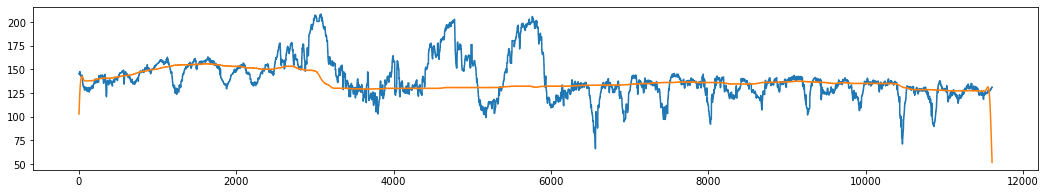

In [83]:
plt.plot(fhr)
plt.plot(baseline)

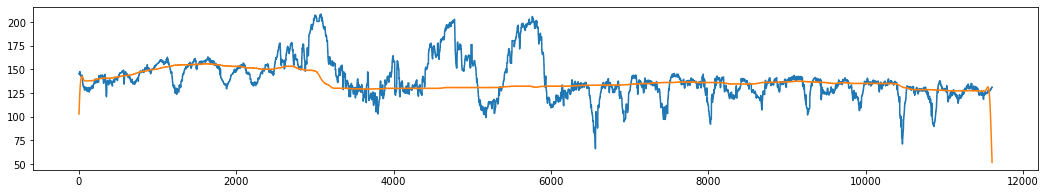

In [85]:
baseline = fhr_aamwmfb(fhr)
plt.plot(fhr)
plt.plot(baseline)